<a href="https://colab.research.google.com/github/cherzs/TomatoCNN-VGG16-Xception/blob/main/sdada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.applications import MobileNetV2, InceptionResNetV2, VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model
from google.colab import files
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import zipfile
# import os

# zip = '/content/drive/MyDrive/data.zip'
# extraxt_to = '/content/sample_data/data'

# with zipfile.ZipFile(zip, 'r') as zip_ref:
#   zip_ref.extractall(extraxt_to)

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the paths
original_dataset_dir = '/content/drive/MyDrive/Dataset/Detection'
base_dir = '/content/drive/MyDrive/Dataset/split_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


In [ ]:
# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Define categories
categories = ['FreshTomato', 'RottenTomato', 'FreshCucumber', 'RottenCucumber']

# Create category directories in train and validation folders
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, category), exist_ok=True)

# Function to split data
def split_data(category):
    category_dir = os.path.join(original_dataset_dir, category)
    images = os.listdir(category_dir)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Copy images to respective directories
    for img in train_images:
        src = os.path.join(category_dir, img)
        dst = os.path.join(train_dir, category, img)
        shutil.copyfile(src, dst)

    for img in val_images:
        src = os.path.join(category_dir, img)
        dst = os.path.join(validation_dir, category, img)
        shutil.copyfile(src, dst)

# Split data for each category
for category in categories:
    split_data(category)


In [ ]:
img_width, img_height = 224, 224
batch_size = 64

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 2306 images belonging to 4 classes.
Found 642 images belonging to 4 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)


Epoch 1/5
36/36 [==============================] - 1961s 55s/step - loss: 0.9108 - accuracy: 0.6302 - val_loss: 0.5847 - val_accuracy: 0.7953
Epoch 2/5
36/36 [==============================] - 1949s 54s/step - loss: 0.5069 - accuracy: 0.8162 - val_loss: 0.4265 - val_accuracy: 0.8562
Epoch 3/5
36/36 [==============================] - 1951s 54s/step - loss: 0.3618 - accuracy: 0.8876 - val_loss: 0.3514 - val_accuracy: 0.8672
Epoch 4/5
36/36 [==============================] - 1937s 54s/step - loss: 0.2954 - accuracy: 0.8996 - val_loss: 0.2773 - val_accuracy: 0.8984
Epoch 5/5
36/36 [==============================] - 1942s 54s/step - loss: 0.2383 - accuracy: 0.9291 - val_loss: 0.2260 - val_accuracy: 0.9328


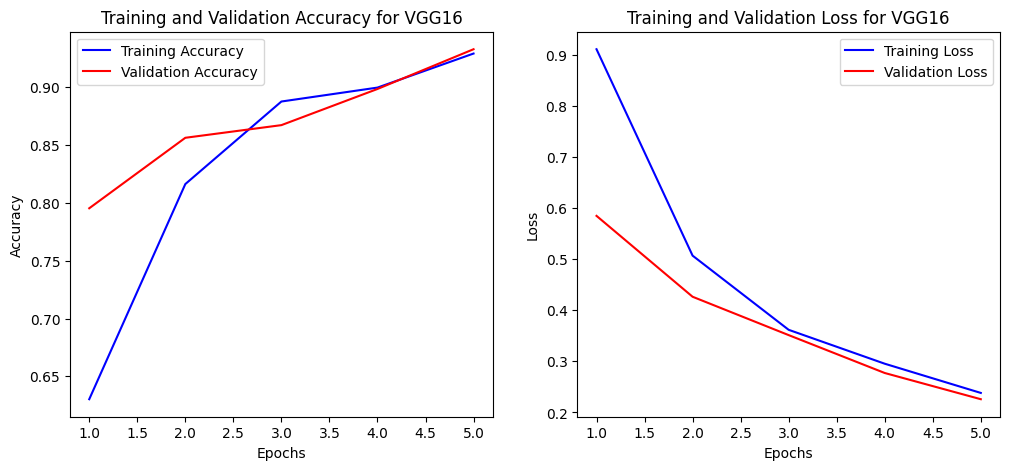

In [ ]:
def plot_history(history, model_name):
    # Ekstrak nilai akurasi dan loss dari history
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    # Plot Training dan Validation Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training dan Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Menggunakan fungsi untuk memplot history dari model Xception
plot_history(history, 'VGG16')


In [ ]:
# Step 4: Evaluasi Model
scores = model.evaluate_generator(validation_generator, steps=validation_generator.samples // batch_size)
print("Akurasi model: %.2f%%" % (scores[1] * 100))

Akurasi model: 93.44%


Found 642 images belonging to 4 classes.
11/11 [==============================] - 452s 40s/step


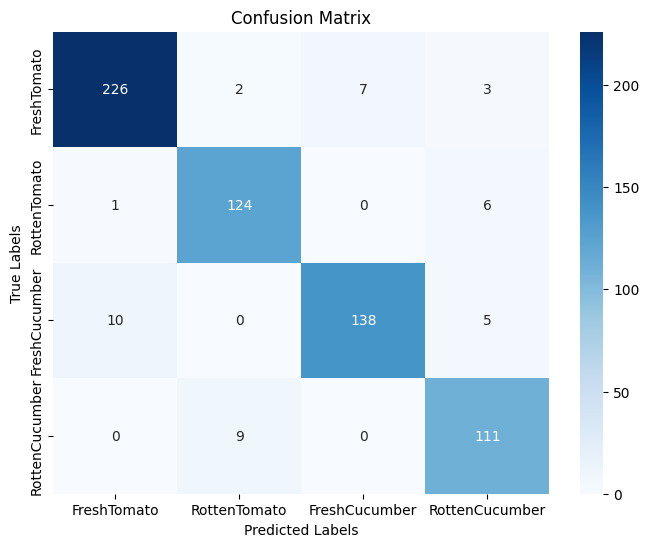

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Path ke direktori validation
validation_dir = '/content/drive/MyDrive/Dataset/split_dataset/validation'

# Membuat generator untuk data validasi
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Melakukan prediksi pada data validasi
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Membuat confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from keras.applications import Xception

# Model Xception
base_model_xception = Xception(weights='imagenet', include_top=False)
x_xception = base_model_xception.output
x_xception = GlobalAveragePooling2D()(x_xception)
x_xception = Dense(1024, activation='relu')(x_xception)
predictions_xception = Dense(4, activation='softmax')(x_xception)

model_xception = Model(inputs=base_model_xception.input, outputs=predictions_xception)

for layer in base_model_xception.layers:
    layer.trainable = False

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
model_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

import matplotlib.pyplot as plt

# Train the model and record history
history_ = model_xception.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)


Epoch 1/5
36/36 [==============================] - 858s 23s/step - loss: 0.2226 - accuracy: 0.9139 - val_loss: 0.0977 - val_accuracy: 0.9641
Epoch 2/5
36/36 [==============================] - 884s 25s/step - loss: 0.1302 - accuracy: 0.9558 - val_loss: 0.0934 - val_accuracy: 0.9625
Epoch 3/5
36/36 [==============================] - 796s 22s/step - loss: 0.0811 - accuracy: 0.9715 - val_loss: 0.0696 - val_accuracy: 0.9797
Epoch 4/5
36/36 [==============================] - 817s 23s/step - loss: 0.0411 - accuracy: 0.9848 - val_loss: 0.0599 - val_accuracy: 0.9797
Epoch 5/5
36/36 [==============================] - 811s 23s/step - loss: 0.0339 - accuracy: 0.9884 - val_loss: 0.0578 - val_accuracy: 0.9859


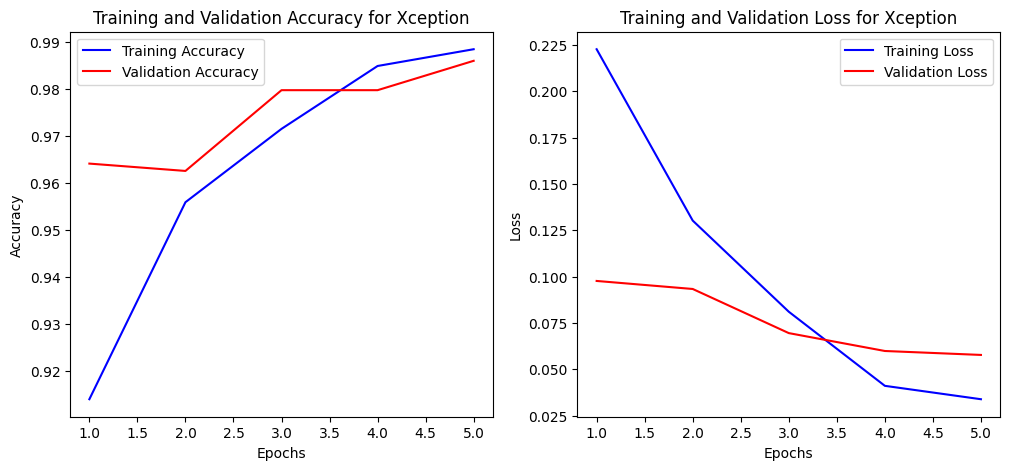

In [ ]:
def plot_history(history, model_name):
    # Ekstrak nilai akurasi dan loss dari history
    train_acc = history_.history['accuracy']
    val_acc = history_.history['val_accuracy']
    train_loss = history_.history['loss']
    val_loss = history_.history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    # Plot Training dan Validation Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training dan Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Menggunakan fungsi untuk memplot history dari model Xception
plot_history(history_, 'Xception')


In [ ]:
# Step 4: Evaluasi Model
scores = model_xception.evaluate_generator(validation_generator, steps=validation_generator.samples // batch_size)
print("Akurasi model: %.2f%%" % (scores[1] * 100))

Akurasi model: 98.59%


11/11 [==============================] - 174s 15s/step


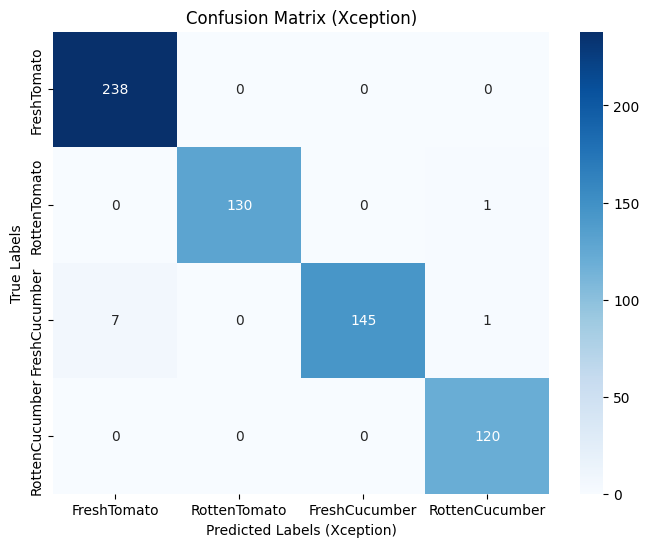

In [ ]:
# Confusion matrix untuk model Xception
y_true_xception = validation_generator.classes
y_pred_xception = model_xception.predict(validation_generator)
y_pred_classes_xception = np.argmax(y_pred_xception, axis=1)

conf_matrix_xception = confusion_matrix(y_true_xception, y_pred_classes_xception)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xception, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels (Xception)')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Xception)')
plt.show()

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from keras.applications.xception import preprocess_input as xception_preprocess

# Fungsi untuk memproses gambar
def load_and_process_image(image_path, model_name, target_size=(224, 224)):
    # Memuat gambar
    img = load_img(image_path, target_size=target_size)
    # Mengonversi gambar ke array
    img_array = img_to_array(img)
    # Menambahkan dimensi batch
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocessing sesuai dengan model yang digunakan
    if model_name == 'VGG16':
        img_array = vgg16_preprocess(img_array)
    elif model_name == 'Xception':
        img_array = xception_preprocess(img_array)
    else:
        raise ValueError("Model tidak dikenal. Pilih antara 'VGG16' atau 'Xception'.")
    return img_array


In [ ]:
# Fungsi untuk melakukan prediksi
def predict_image(model, image_path, model_name):
    # Memuat dan memproses gambar
    img_array = load_and_process_image(image_path, model_name)
    # Melakukan prediksi
    predictions = model.predict(img_array)
    # Mengonversi prediksi ke label
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class, predictions

# Mapping label sesuai dengan kelas dalam data generator
label_mapping = {v: k for k, v in train_generator.class_indices.items()}

# Fungsi untuk mendapatkan nama label dari prediksi
def get_label_name(predicted_class):
    return label_mapping[predicted_class[0]]


In [ ]:
# Path ke gambar yang akan diprediksi
image_path = '/content/drive/MyDrive/Dataset/Detection/RottenTomato/rottenTomato (101).jpg'

# Melakukan prediksi dengan model VGG16
predicted_class_vgg16, predictions_vgg16 = predict_image(model, image_path, 'VGG16')
label_vgg16 = get_label_name(predicted_class_vgg16)
print(f"Prediksi VGG16: {label_vgg16}, Probabilitas: {predictions_vgg16}")


1/1 [==============================] - 1s 552ms/step
Prediksi VGG16: FreshTomato, Probabilitas: [[0.0000000e+00 1.0000000e+00 0.0000000e+00 1.3175713e-17]]


In [ ]:
# Melakukan prediksi dengan model Xception
predicted_class_xception, predictions_xception = predict_image(model_xception, image_path, 'Xception')
label_xception = get_label_name(predicted_class_xception)
print(f"Prediksi Xception: {label_xception}, Probabilitas: {predictions_xception}")


1/1 [==============================] - 0s 205ms/step
Prediksi Xception: RottenTomato, Probabilitas: [[1.06480606e-07 2.92662298e-04 5.95769461e-06 9.99701202e-01]]


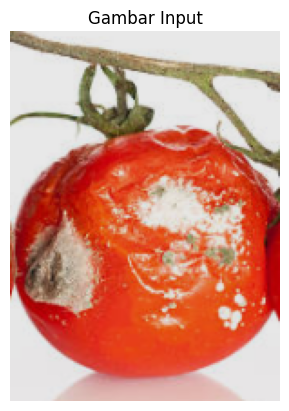

In [ ]:
# Memuat dan menampilkan gambar
img = load_img(image_path)
plt.imshow(img)
plt.axis('off')
plt.title('Gambar Input')
plt.show()